In [17]:
import numpy as np
import pint.models as model
import pint.derived_quantities as dq
import matplotlib.pyplot as plt
from matplotlib import gridspec
from astropy import units as u
from astropy.time import Time
import matplotlib as mpl
from scipy.optimize import curve_fit
import table_utils as tu
import glob
# Set some plotting parameters
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
fig_width = 10.0
fig_height = 6.0
fig_size = [fig_width,fig_height]
params = {'backend': 'pdf',
          'font.size'         : 14*fig_width/8.5,
          'axes.labelsize'    : 14*fig_width/8.5,
          'legend.fontsize'   : 11*fig_width/8.5,
          'xtick.labelsize'   : 14*fig_width/8.5,
          'ytick.labelsize'   : 14*fig_width/8.5,
          'text.usetex'       : True,
          'figure.figsize'    : fig_size,
          'axes.unicode_minus': True}
mpl.rcParams.update(params)
colors = {'blue':    '#377eb8', 
          'orange':  '#ff7f00',
          'green':   '#4daf4a',
          'pink':    '#f781bf',
          'brown':   '#a65628',
          'purple':  '#984ea3',
          'gray':    '#999999',
          'red':     '#e41a1c',
          'yellow':  '#dede00'}
%matplotlib inline

In [10]:
def DMdelay(nu, dm, offset): # dm in pc/cc, frequencies in MHz
#     nu_hi = max(nu1,nu2)
#     nu_lo = min(nu1,nu2)
    return 4.15e6 * dm * nu**-2 + offset

def func(x,a,b,c):
    return a*x**b+c

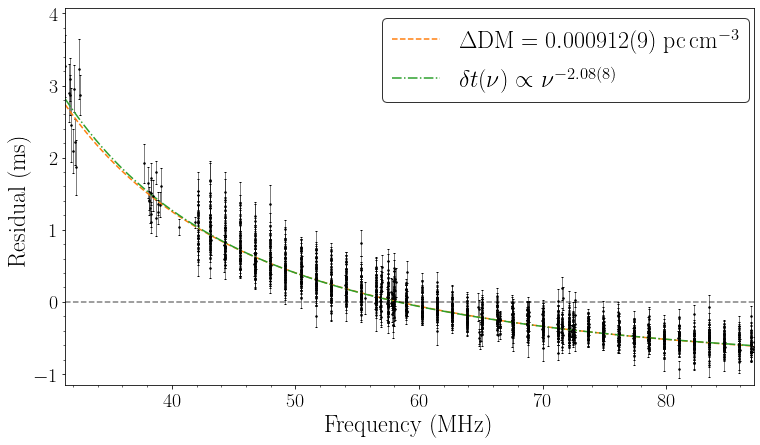

In [84]:
#res_file = "data/J1327+3423_LWA_DM4.1829_residuals.dat"
res_file = "data/J1327+3423_LWA_DM4.1829_residuals.refold.dat"

name = "PSR J1327+3423"

fig = plt.figure(figsize=fig_size)
ax = fig.add_subplot(111)

res, err, frq = np.loadtxt(res_file,dtype='float',unpack=True,usecols=[1,2,5])

#res -= res[np.argmax(frq)]

# Get phase info
psr = name.split()[1]
par_fname = f'data/{psr}_fiore+23.par'

with open(par_fname, 'r') as infile:
    for l in infile.readlines():
        if l.startswith("F0"):
            f0      = float(l.split()[1])*u.Hz
            f0err   = float(l.split()[3])*u.Hz
        elif l.startswith("F1"):
            f1      = float(l.split()[1])*u.Hz/u.s
            f1err   = float(l.split()[3])*u.Hz/u.s
        else:
            pass

p0,p0err,p1,p1err = dq.pferrs(f0,f0err,f1,f1err)

# ax_R = ax.twinx()

res_color = 'black'

ax.errorbar(frq,res,yerr=err,fmt='o',mfc=res_color,mec=res_color,ecolor=res_color,ms=1.5,capsize=1.,elinewidth=0.5)

min_y = 1.1*min(res-err)
max_y = 1.1*max([np.abs(r)+np.abs(e) for r,e in zip(res,err)])

ax.set_ylim([min_y,max_y])
# ax_R.set_ylim([min_y/p0.to(u.ms).value,max_y/p0.to(u.ms).value])
ax.minorticks_on()
# ax_R.minorticks_on()
ax.tick_params(axis='both', labelsize=20)

bigfont = 24

# 3 labeled ticks: https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
# ax_R.yaxis.set_major_locator(plt.MaxNLocator(3))
# ax_R.ticklabel_format(useOffset=False,style='plain')

# Calculate *global* xlims
# x_lims = [min_yr,max_yr]
# ax.set_xlabel('Year')
x_lims = [min(frq),max(frq)]
ax.set_xlabel('Frequency (MHz)',fontsize=bigfont)
ax.set_xlim(x_lims)

# Plot center lines using global xlims
ax.plot(x_lims,[0,0],ls='--',color='black',alpha=0.5,zorder=10)
ax.ticklabel_format(useOffset=False,style='plain')

# Plot DM delay
fs = np.arange(min(frq),max(frq),0.1)
#pars,pcov = curve_fit(f=quadratic,xdata=frq,ydata=res,sigma=err,p0=[1,1,1],bounds=([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf]))
# a, b, c = pars[0], pars[1], pars[2]
# ax.plot(fs,quadratic(fs,a,b,c))

pars,pcov = curve_fit(f=DMdelay,xdata=frq,ydata=res,sigma=err,p0=[1,1],bounds=([0,-np.inf],[1.0,np.inf]))
dm, offset = pars[0], pars[1]
dm_err, offset_err = np.sqrt(np.diag(pcov))
dm_tex = tu.ufve(dm, dm_err)
ax.plot(fs,DMdelay(fs,dm,offset),label=r"$\Delta \mathrm{DM} = %s\;\mathrm{pc\,cm}^{-3}$" % dm_tex,ls='--')

pars,pcov = curve_fit(f=func,xdata=frq,ydata=res,sigma=err,p0=[4.15e6*dm,-2,offset])#,bounds=([0,-100.,-100.],[1.0,100.,100.]))
coeff, power, offset = pars[0], pars[1], pars[2]
coeff_err, power_err, offset_err = np.sqrt(np.diag(pcov))
dm = coeff/4.15e6
dm_err = coeff_err/4.15e6
dm_tex = tu.ufve(dm, dm_err)
power_tex = tu.ufve(power, power_err)
#ax.plot(fs,func(fs,coeff,power,offset),label=r"$\delta t(\nu) = %s \times (4.15 \times 10^6\;\mathrm{ms})\,\nu_\mathrm{MHz}^{%s}$" % (dm_tex, power_tex),ls='-.') #{coeff:.4f} {power:.2f}
ax.plot(fs,func(fs,coeff,power,offset),label=r"$\delta t(\nu) \propto \nu^{%s}$" % power_tex,ls='-.') #{coeff:.4f} {power:.2f}

fig.legend(loc=4,edgecolor='black',bbox_to_anchor=(1.01,0.75),fontsize=bigfont)

# Add common ylabels, adjust layout and save figure
fig.text(-0.02, 0.55,r'Residual (ms)', ha='center', va='center', rotation='vertical',fontsize=bigfont)
fig.subplots_adjust(hspace=0)
fig.tight_layout(pad=0.0, w_pad=0.5, h_pad=0.25)

fig.savefig('resLWA.pdf',format='pdf',bbox_inches='tight',pad_inches=0.25)

In [45]:
profs = ["J1327+3423_35.1MHz_fiore+23.profile", "J1327+3423_49.8MHz_fiore+23.profile", \
         "J1327+3423_64.5MHz_fiore+23.profile", "J1327+3423_79.2MHz_fiore+23.profile"]
profs.reverse()

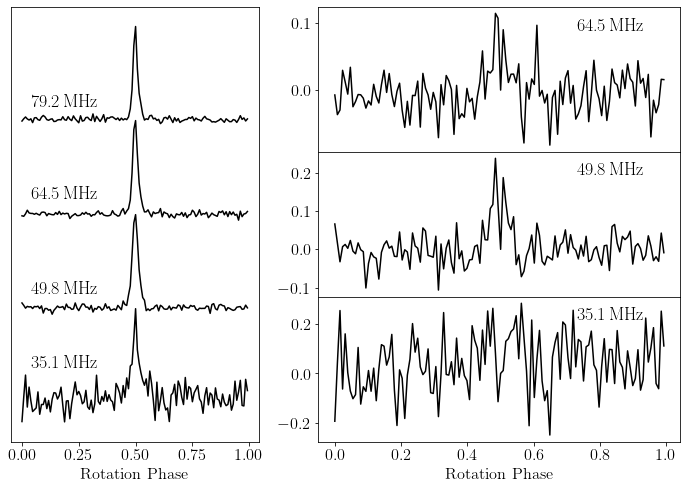

In [63]:
# spec = gridspec.GridSpec(ncols=2, nrows=3,
#                          hspace=0.3, height_ratios=[3, 1, 1], width_ratios=[1,1])

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(12)

#profs_ax = fig.add_subplot(spec[0])
profs_ax = fig.add_subplot(1, 3, 1)
#plt.title("PSR J1327+3423 LWA1 Pulse Profiles",fontsize=18)
plot_num = 0
x,y,z,profdata79 = np.loadtxt(f"data/{profs[0]}",dtype='float',unpack=True,skiprows=1)
profs_ax.set_xlabel("Rotation Phase")
profs_ax.set_yticks([])
dy = 0.5
#prof_colors = [colors['blue'],colors['green'],colors['orange'],colors['red']]
prof_colors = ['black','black','black','black']
for prof in profs:
    freq = prof.split("_")[1]
    x,y,z,profdata = np.loadtxt(f"data/{prof}",dtype='float',unpack=True,skiprows=1)
    nbin = 128
    phases = np.arange(nbin)/float(nbin)
    profs_ax.plot(phases, profdata / np.max(profdata) - plot_num*dy,c=prof_colors[plot_num//2])
    if plot_num > 0:
        #ax = fig.add_subplot(spec[plot_num])
        ax = fig.add_subplot(3, 2, plot_num)
        ax.plot(phases, profdata / np.max(profdata) - profdata79 / np.max(profdata79),c=prof_colors[plot_num//2])
        #ax.text(0.97,1.07,f"{float(freq.strip('MHz')):.0f} MHz profile $-$ 79 MHz profile (normalized)",rotation=0,size=16,va='center',ha='right',transform=ax.transAxes)
        ax.set_xlabel("Rotation Phase")
        ax.text(0.9,0.87,f"{freq.split('M')[0]}\,M{freq.split('M')[1]}",c='black',rotation=0,size=18,va='center',ha='right',transform=ax.transAxes)
    plot_num += 2
#leg = profs_ax.legend()
# profs_ax.text(0.35,0.18,"35.1 MHz",c=colors['red'],rotation=0,size=18,va='center',ha='right',transform=profs_ax.transAxes)
# profs_ax.text(0.35,0.18+dy/2.5-0.03,"49.8 MHz",c=colors['orange'],rotation=0,size=18,va='center',ha='right',transform=profs_ax.transAxes)
# profs_ax.text(0.35,0.18+dy*2/2.5-0.01,"64.5 MHz",c=colors['green'],rotation=0,size=18,va='center',ha='right',transform=profs_ax.transAxes)
# profs_ax.text(0.35,0.18+dy*3/2.5,"79.2 MHz",c=colors['blue'],rotation=0,size=18,va='center',ha='right',transform=profs_ax.transAxes)

profs_ax.text(0.35,0.18,"35.1\,MHz",c='black',rotation=0,size=18,va='center',ha='right',transform=profs_ax.transAxes)
profs_ax.text(0.35,0.18+dy/2.5-0.03,"49.8\,MHz",c='black',rotation=0,size=18,va='center',ha='right',transform=profs_ax.transAxes)
profs_ax.text(0.35,0.18+dy*2/2.5-0.01,"64.5\,MHz",c='black',rotation=0,size=18,va='center',ha='right',transform=profs_ax.transAxes)
profs_ax.text(0.35,0.18+dy*3/2.5,"79.2\,MHz",c='black',rotation=0,size=18,va='center',ha='right',transform=profs_ax.transAxes)

fig.subplots_adjust(wspace=-0.15,hspace=0)#0.65)
fig.savefig("LWA_profiles.pdf",format="pdf",bbox_inches='tight',pad_inches=0.25)